# ML Pipeline Preparation
Follow the instructions below to help you create your ML pipeline.
### 1. Import libraries and load data from database.
- Import Python libraries
- Load dataset from database with [`read_sql_table`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_sql_table.html)
- Define feature and target variables X and Y

In [1]:
# import libraries

import re
import nltk
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from sqlalchemy import create_engine
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.naive_bayes import ComplementNB,MultinomialNB,BernoulliNB
from sklearn.multioutput import MultiOutputClassifier
from sklearn.metrics import classification_report,accuracy_score,f1_score,precision_score,recall_score

nltk.download('punkt') #tokenizer
nltk.download('stopwords') 
nltk.download('wordnet')# lemmatizer

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/clairegong/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/clairegong/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/clairegong/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [2]:
engine = create_engine('sqlite:///DisasterResponse.db')
df = pd.read_sql('SELECT * FROM messages', engine)

In [3]:
df.head(1)

message   genre  related  \
0  Weather update - a cold front from Cuba that c...  direct        1   

   request  offer  aid_related  medical_help  medical_products  \
0        0      0            0             0                 0   

   search_and_rescue  security  ...  aid_centers  other_infrastructure  \
0                  0         0  ...            0                     0   

   weather_related  floods  storm  fire  earthquake  cold  other_weather  \
0                0       0      0     0           0     0              0   

   direct_report  
0              0  

[1 rows x 37 columns]

In [4]:
df.shape

(26215, 37)

In [5]:
# load data from database
# later i found because my process_data.py is a bit different from the notebook version 
#so database is one column different...

def load_data():
    engine = create_engine('sqlite:///DisasterResponse.db')
    df = pd.read_sql('SELECT * FROM messages', engine)
    #this database already remove 'child_alone' column, because values are all 0, no use for training
    X = df.message.values
    Y = df.iloc[:,2:].values
#     labels=df.iloc[:,2:].columns
    return X,Y#,labels


### 2. Write a tokenization function to process your text data

 #### Three useful methods of  text feature extraction. I don't know when to use each yet.

CountVectorizer - Bag of Words

**TfidfTransformer - TF-IDF values**

TfidfVectorizer - Bag of Words AND TF-IDF values

In [6]:
def tokenize(text):
    # normalize case and remove punctuation
    text = re.sub(r"[^a-zA-Z0-9]", " ", text.lower())
    
    # tokenize text
    tokens = word_tokenize(text)
    
    # lemmatize and remove stop words
    lemmatizer = WordNetLemmatizer()
    stop_words = stopwords.words("english")
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]

    return tokens

### 3. Build a machine learning pipeline
This machine pipeline should take in the `message` column as input and output classification results on the other 36 categories in the dataset. You may find the [MultiOutputClassifier](http://scikit-learn.org/stable/modules/generated/sklearn.multioutput.MultiOutputClassifier.html) helpful for predicting multiple target variables.

In [7]:
def make_model(clf):
    pipeline = Pipeline([
        ('vect', CountVectorizer(tokenizer=tokenize)),
        ('tfidf', TfidfTransformer()),
        ('clf', clf)
     ])
    return pipeline

In [8]:
def make_cv_model(clf):
    pipeline = Pipeline([
        ('vect', CountVectorizer(tokenizer=tokenize)),
        ('tfidf', TfidfTransformer()),
        ('clf', clf)
     ])
        
    parameters = {
        'vect__ngram_range': ((1, 1), (1, 2)),
        'vect__max_df': (0.75, 1.0),
        'tfidf__use_idf': (True, False)
    }

    cv = GridSearchCV(pipeline, param_grid=parameters, cv=3)

    return cv

### 4. Train pipeline
- Split data into train and test sets
- Train pipeline

### 5. Test your model
Report the f1 score, precision and recall for each output category of the dataset. You can do this by iterating through the columns and calling sklearn's `classification_report` on each.

In [9]:
labels=df.columns[2:].tolist()
def report(Y_test,Y_preds,labels=labels):
    for i in range(35):
        print(classification_report(Y_test[:,i], Y_preds[:,i]),('for label:'+labels[i].upper()))
#Macro-Average: (class1 + class2+...)/no_class	 #treat classes equally; 
#Micro-Average: total_true/total	#treat instances equally, so classes with larger dataset carry more weight

In [10]:
def scores(Y_test,Y_preds):
    accuracy_list=[accuracy_score(Y_test[:,i], Y_preds[:,i])for i in range(35)]
    # macro treat class equally, thus if rare class predicting badly affects score alot
    macro_f1_list=[f1_score(Y_test[:,i], Y_preds[:,i], average='macro')for i in range(35)]
    macro_precision_list=[precision_score(Y_test[:,i], Y_preds[:,i], average='macro')for i in range(35)]
    macro_recall_list=[recall_score(Y_test[:,i], Y_preds[:,i], average='macro')for i in range(35)]    
    micro_precision_list=[precision_score(Y_test[:,i], Y_preds[:,i], average='micro')for i in range(35)]
    micro_recall_list=[recall_score(Y_test[:,i], Y_preds[:,i], average='micro')for i in range(35)]    
    print('accuracy/micro f1_score:',sum(accuracy_list)/35)   
    print('micro precision_list:',sum(micro_precision_list)/35)
    print('micro recall_list',sum(micro_recall_list)/35)   
    print('macro f1_score',sum(macro_f1_list)/35)
    print('macro precision_list:',sum(macro_precision_list)/35)
    print('macro recall_list',sum(macro_recall_list)/35)     

### 6. Improve your model/GridSearch
Use grid search to find better parameters. 

In [11]:
nb_clf=MultiOutputClassifier(MultinomialNB())
nb_clf2=MultiOutputClassifier(ComplementNB()) #sklearn 0.20+

def main_cv(clf=nb_clf2):
    X, Y = load_data()
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, random_state=1)

    model=make_cv_model(clf)

    # train classifier
    model.fit(X_train, Y_train)
    print(model.best_params_)

    # predict on test data
    Y_preds = model.predict(X_test)

    # display weighted f1, accuracy, macro f1
    scores(Y_test,Y_preds)
    return model,X_test,Y_test,Y_preds


# model,X_test,Y_test,Y_preds=main_cv()

### 7. Test your model
Show the accuracy, precision, and recall of the tuned model.  

Since this project focuses on code quality, process, and  pipelines, there is no minimum performance metric needed to pass. However, make sure to fine tune your models for accuracy, precision and recall to make your project stand out - especially for your portfolio!

In [12]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
kn_clf=MultiOutputClassifier(KNeighborsClassifier(n_neighbors=5)) 
# macro f1_score 0.513189644439006
# macro precision_list: 0.7186748805139221
# macro recall_list 0.5231607377289993
rf_clf=MultiOutputClassifier(RandomForestClassifier(n_estimators=10))
# macro f1_score 0.6081378240597004
# macro precision_list: 0.7773213485942109
# macro recall_list 0.5887820242226837

def main(clf=nb_clf2):
    X, Y = load_data()
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, random_state=1)

    model=make_model(clf)

    # train classifier
    model.fit(X_train, Y_train)

    # predict on test data
    Y_preds = model.predict(X_test)

    # display averaged f1_score
    scores(Y_test,Y_preds)
    return model,X_test,Y_test,Y_preds


model,X_test,Y_test,Y_preds=main()


accuracy/micro f1_score: 0.9320981734164523
micro precision_list: 0.9320981734164523
micro recall_list 0.9320981734164523
macro f1_score 0.5753383686142565
macro precision_list: 0.6050804133469594
macro recall_list 0.5667665905700707


In [13]:
report(Y_test,Y_preds)

              precision    recall  f1-score   support

           0       0.74      0.42      0.54      1548
           1       0.84      0.95      0.89      4956
           2       0.51      0.48      0.49        50

    accuracy                           0.82      6554
   macro avg       0.70      0.62      0.64      6554
weighted avg       0.81      0.82      0.81      6554
 for label:RELATED
              precision    recall  f1-score   support

           0       0.92      0.93      0.92      5423
           1       0.63      0.59      0.61      1131

    accuracy                           0.87      6554
   macro avg       0.77      0.76      0.77      6554
weighted avg       0.87      0.87      0.87      6554
 for label:REQUEST
              precision    recall  f1-score   support

           0       1.00      0.99      0.99      6525
           1       0.00      0.00      0.00        29

    accuracy                           0.99      6554
   macro avg       0.50      0.50     

### 8. Try improving your model further. Here are a few ideas:
* try other machine learning algorithms
* add other features besides the TF-IDF

In [21]:
 def display_category(text,model=model):
    # display prediction of a message in dataframe format
    cat=model.predict(text)[0]
    classification_results = dict(zip(labels, cat))
    print(classification_results)
    df=pd.DataFrame({'prediction': cat}, index=labels)
    df= df[df.prediction==1]
    return df

In [23]:
# try pre-trained text
text1=["We are more than 50 people sleeping on the street. Please help us find tent, food."]
display_category(text1)

{'related': 1, 'request': 1, 'offer': 0, 'aid_related': 1, 'medical_help': 0, 'medical_products': 0, 'search_and_rescue': 0, 'security': 0, 'military': 0, 'water': 0, 'food': 0, 'shelter': 1, 'clothing': 0, 'money': 0, 'missing_people': 0, 'refugees': 0, 'death': 0, 'other_aid': 0, 'infrastructure_related': 0, 'transport': 0, 'buildings': 0, 'electricity': 0, 'tools': 0, 'hospitals': 0, 'shops': 0, 'aid_centers': 0, 'other_infrastructure': 0, 'weather_related': 0, 'floods': 0, 'storm': 0, 'fire': 0, 'earthquake': 0, 'cold': 0, 'other_weather': 0, 'direct_report': 1}


prediction
related                 1
request                 1
aid_related             1
shelter                 1
direct_report           1

In [16]:
# try some random text
display_category(['i am having a fever']) 

prediction
related                1
aid_related            1
medical_help           1

 #### Important! Jupyter code should be exactly like production code, thus production code is predictable.  If latter changes, jupyter code must change as well.
- **BernoulliNB/KNN**, new text messages always predict 'related', this means BernoulliNB is a bad predictor.

- **MultinomialNB** is quite inaccurate too, but the output is not consistently 'related', but still not useful.
 
- **RandomForest**, good performance on training data, **very bad on new data, most common is no category.**
  
 <font color=green>Among above, **ComplementNB**(available ver 0.20+) prediction for new messages is much better!</font>
 
 So I finally found that: reason why **my code performance is bad, it is simply because the model is different!**<br>
 But what's the suitable metrics for this problem, as it does not show BernoulliNB is bad and ComplementNB is good?
 
>- KNeighborsClassifier(n_neighbors=5)) (BAD for new text)
>- macro f1_score 0.513189644439006
>- macro precision_list: 0.7186748805139221
>- macro recall_list 0.5231607377289993

>- RandomForestClassifier(n_estimators=10)) (BAD for new text)
>- macro f1_score 0.6081378240597004
>- macro precision_list: 0.7773213485942109
>- macro recall_list 0.5887820242226837

>- BernoulliNB:  (BAD for new text)
>- weighted f1_score 0.9255590554451469
>- accuracy/micro f1_score: 0.9385362628420302
>- macro f1_score 0.5816615209366508

>- ComplementNB: (Very good on new text)
>- weighted f1_score 0.9244240538281583
>- accuracy/micro f1_score: 0.9339843352659953
>- macro f1_score 0.5871345250416382

### 9. Export your model as a pickle file

In [17]:
from joblib import dump, load
#save
dump(model, 'model.pkl')
#load
model_load = load('model.pkl')


### 11. Use this notebook to complete `train.py`
Use the template file attached in the Resources folder to write a script that runs the steps above to create a database and export a model based on a new dataset specified by the user.

### Bug record:
1. Database code different between workspace and notebook, in workspace/ETL_pipeline/transform drop one more column .
2. My initial model choice is `ComplementNB`, but only available in sklearn 0.20+, while IDE version is 0.19, so not compatible. 
3. Not knowing above reason yet, i thought i can try a different model, its prediction is so off i thought there is a bug in model handling.. it turns off just a bad model.
4. Still not upgrading sklearn yet, i try many more models, the results are just bad.
5. Finally, to have the best performing model, it still took me some time just to update the sklearn version.
6. After time after upgrate, sklean.externals not working and need to update numpy and scipy also to stop the errors.

Finally, everything works now!

### Make visualization for Flask

In [33]:
engine = create_engine('sqlite:///DisasterResponse.db')
df = pd.read_sql('SELECT * FROM messages', engine)
df.head()

message   genre  related  \
0  Weather update - a cold front from Cuba that c...  direct        1   
1            Is the Hurricane over or is it not over  direct        1   
2                    Looking for someone but no name  direct        1   
3  UN reports Leogane 80-90 destroyed. Only Hospi...  direct        1   
4  says: west side of Haiti, rest of the country ...  direct        1   

   request  offer  aid_related  medical_help  medical_products  \
0        0      0            0             0                 0   
1        0      0            1             0                 0   
2        0      0            0             0                 0   
3        1      0            1             0                 1   
4        0      0            0             0                 0   

   search_and_rescue  security  ...  aid_centers  other_infrastructure  \
0                  0         0  ...            0                     0   
1                  0         0  ...            0                     0   
2                  0         0  ...            0                     0   
3                  0         0  ...            0                     0   
4                  0         0  ...            0                     0   

   weather_related  floods  storm  fire  earthquake  cold  other_weather  \
0                0       0      0     0           0     0              0   
1                1       0      1     0           0     0              0   
2                0       0      0     0           0     0              0   
3                0       0      0     0           0     0              0   
4                0       0      0     0           0     0              0   

   direct_report  
0              0  
1              0  
2              0  
3              0  
4              0  

[5 rows x 37 columns]

In [57]:
#graph one data
category_counts=df.iloc[:,2:].sum().sort_values(ascending=False)
categories=list(category_counts.index)

In [73]:
#graph two data
text=' '.join(df.message.tolist())
tokenized_text=tokenize(text)
tokenized_text=' '.join(tokenized_text)

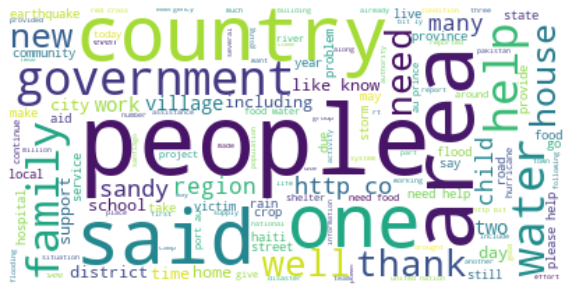

In [90]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
%matplotlib inline

wordcloud = WordCloud(max_font_size=70, max_words=200, background_color="white").generate(tokenized_text)

# Display the generated image:
plt.figure(figsize=[10,10])
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.savefig('wordcloud.jpg')
plt.show()

In [97]:
import plotly.express as px

fig = px.imshow(wordcloud)

#below code not working
fig.update_layout(autosize=False,width=1000,height=500)
fig.show()